In [1]:
import pandas as pd
import numpy as np
import duckdb # библиотека для работы с SQL
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
users = pd.read_csv('users.csv')
sessions_closed = pd.read_csv('sessions_closed.csv')

#### Я заметил, что в таблице users отсутсвует некоторые пользователи, которые есть в таблице session_closed, и наоборот.

In [3]:
sc_uniq = sessions_closed['user_id'].unique() # количество ункальных пользователей в таблице sessions_closed
users_uniq = users['user_id'].unique() # количество ункальных пользователей в таблице users

In [4]:
# количество пользователей отсутсвующих в таблице users
np.isin(sc_uniq, users_uniq, invert=True).sum()

29694

In [5]:
# количество пользователей отсутсвующих в таблице sessions_closed
np.isin(users_uniq, sc_uniq, invert=True).sum()

85591

Пользователи из таблицы session_closed для нас важнее, так как там содержится информация об их действиях. Значит за основу берем таблицу session_closed, при этом у некоторых пользователей будут отсутствовать параметры role и create_at(дата регистрации). Выполню SQL запрос и с помощью LEFT JOIN соеденю таблицы. Также сразу приведу даты к нужному типу данных

In [6]:
# это будет наш основной запрос
query = ''' 
SELECT 
    sc.user_id, 
    u.role,
    strftime('%Y-%m-%d', STRPTIME(u.create_at, '%d/%m/%y %H:%M'))::date as registration_date,
    sc.id as session_id,
    sc.status,
    sc.created_at::date as created_at,
    sc.updated_at::date as updated_at
    FROM sessions_closed sc
LEFT JOIN users u ON u.user_id = sc.user_id
'''

In [7]:
df_result = duckdb.query(query).to_df()

In [8]:
df_result.head()

,user_id,role,registration_date,session_id,status,created_at,updated_at
0,213367,full,2023-11-25,2201484,102,2023-11-25,2023-11-25
1,138374,full,2023-06-18,2201487,102,2023-11-25,2023-12-02
2,87639,full,2022-11-10,2201496,100,2023-11-25,2023-11-26
3,9651,full,2022-01-31,2201499,103,2023-11-25,2023-11-30
4,52626,full,2022-08-18,2201514,103,2023-11-25,2023-11-30


In [9]:
df_result.shape

(748123, 7)

In [10]:
# посмотрю количество дубликатов
df_result.duplicated().sum()

0

In [11]:
df_result.loc[df_result['role'].isna()]

,user_id,role,registration_date,session_id,status,created_at,updated_at
1022,150034,None,NaT,2201490,103,2023-11-25,2023-11-29
1023,198504,None,NaT,2201493,102,2023-11-25,2023-11-26
1024,213369,None,NaT,2201502,103,2023-11-25,2023-12-08
1025,168429,None,NaT,2201505,103,2023-11-25,2023-11-29
1026,121639,None,NaT,2201508,102,2023-11-25,2023-11-25
...,...,...,...,...,...,...,...
748118,52281,None,NaT,615916,103,2022-08-25,2022-08-30
748119,4157,None,NaT,615922,100,2022-08-25,2022-08-26
748120,54863,None,NaT,615937,102,2022-08-25,2022-08-26
748121,23876,None,NaT,615946,103,2022-08-26,2022-08-29


In [12]:
# посмотрю в целом на данные
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748123 entries, 0 to 748122
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            748123 non-null  int64         
 1   role               375517 non-null  object        
 2   registration_date  375517 non-null  datetime64[us]
 3   session_id         748123 non-null  int64         
 4   status             748123 non-null  int64         
 5   created_at         748123 non-null  datetime64[us]
 6   updated_at         748123 non-null  datetime64[us]
dtypes: datetime64[us](3), int64(3), object(1)
memory usage: 40.0+ MB


In [13]:
# поработаю с пропущенными значениями столбцы role и registration_date
# в столбце role в основной массе представлены значения full
df_result['role'].value_counts()

role
full          371330
standard        4175
simplified        12
Name: count, dtype: int64

In [14]:
# в столюце role, заменю все пропущенные значения на full
df_result['role'] = df_result['role'].fillna('full')

#### С заменой пропущенных значений в столбце 'registration_date' есть несколько вариантов
1) Так как user_id идут по порядку, то можно было бы для пропущенного значения 'registration_date' брать дату регистрации предыдущего по порядку юзера
2) Выбираю вариант немного проще. Пуска дата регистрации будет равна дате создания первой сессии

In [15]:
df_result['registration_date'] = df_result['registration_date'].fillna(df_result['created_at'] )

In [16]:
# пропущенных значений нет
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748123 entries, 0 to 748122
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            748123 non-null  int64         
 1   role               748123 non-null  object        
 2   registration_date  748123 non-null  datetime64[us]
 3   session_id         748123 non-null  int64         
 4   status             748123 non-null  int64         
 5   created_at         748123 non-null  datetime64[us]
 6   updated_at         748123 non-null  datetime64[us]
dtypes: datetime64[us](3), int64(3), object(1)
memory usage: 40.0+ MB


#### Предобработка данных завершина, перейду к группировкам.
Сгруппирую данные по user_id и role, и найду дату регистрации для каждого пользователя

In [17]:
df_reg_date = df_result.groupby(['user_id', 'role'], as_index=False).agg({'registration_date':'min'})

Найду дату последней активности. Буду искать дату последней активности в зависимости от статуса
- 103 - дата последней активности = updated_at
- 102 - дата последней активности = created_at
- 100 - дата последней активности = created_at
- 101 - дата последней активности = updated_at

In [18]:
di = {103:'updated_at', 102:'created_at', 100:'created_at', 101:'updated_at'}

In [19]:
df_result['last_active_date'] = df_result.apply(
    lambda x: x['updated_at'] if x['status'] in (101, 103) else x['created_at'], axis=1
)

In [20]:
df_last_active_date = df_result.groupby('user_id', as_index=False)['last_active_date'].max()

#### Выполню расчет количества успешных выполнений заданий в разрезе года

In [21]:
# оставляю данные со статусом 103
count_success_year = df_result.loc[df_result['status'] == 103].copy()

In [22]:
count_success_year.shape

(636990, 8)

In [23]:
# добавлю колонку с годом
count_success_year['year'] = count_success_year['updated_at'].dt.year

In [24]:
# сгруппировал данные по пользователям и годам, и посчитал количество сессий для каждого года
count_success_year = count_success_year.groupby(['user_id', 'year'], as_index=False).size()

In [25]:
# использую pivot, чтобы года стали колонками
count_success_year = count_success_year.pivot(index='user_id', columns='year', values='size').reset_index().fillna(0)

In [26]:
count_success_year

year,user_id,2021,2022,2023,2024
0,79,1.0,2.0,1.0,0.0
1,80,2.0,1.0,1.0,0.0
2,82,1.0,0.0,0.0,0.0
3,83,2.0,3.0,1.0,0.0
4,84,2.0,5.0,1.0,0.0
...,...,...,...,...,...
46598,231159,0.0,0.0,0.0,1.0
46599,231193,0.0,0.0,1.0,0.0
46600,231195,0.0,0.0,1.0,0.0
46601,231197,0.0,0.0,0.0,1.0


### У нас получилось 3 датафрейма. Проверю их размерность, а затем соединю между собой

In [27]:
df_last_active_date.shape

(59456, 2)

In [28]:
df_reg_date.shape

(59456, 3)

In [29]:
count_success_year.shape

(46603, 5)

В датафрейме count_success_year 46603 строк, а в двух других датафреймах 59456. Это произошло из-за того, что не все пользователи выполнили хотя бы одно успешное задание со статусом = 103

In [30]:
df_result = pd.merge(df_reg_date, df_last_active_date, how='inner', on='user_id')

In [31]:
df_result = pd.merge(df_result, count_success_year, how='left', on='user_id')

In [32]:
df_result.sample(10)

,user_id,role,registration_date,last_active_date,2021,2022,2023,2024
48314,165258,full,2023-08-27,2023-08-27,NaN,NaN,NaN,NaN
6239,11442,full,2022-02-08,2022-06-17,0.0,1.0,0.0,0.0
17456,38849,full,2022-07-23,2022-07-23,0.0,1.0,0.0,0.0
1365,2213,full,2022-05-29,2022-05-29,0.0,1.0,0.0,0.0
3499,5566,full,2022-01-13,2023-11-25,0.0,22.0,8.0,0.0
16701,36859,full,2022-07-20,2022-07-20,0.0,1.0,0.0,0.0
9697,19312,full,2022-03-19,2022-11-21,0.0,1.0,0.0,0.0
8979,17603,full,2022-03-17,2022-03-17,0.0,1.0,0.0,0.0
14991,32327,full,2022-06-17,2023-08-21,0.0,2.0,1.0,0.0
3751,6080,full,2021-12-22,2022-01-10,1.0,1.0,0.0,0.0


Заменю пропущенные значения в столбцах с годами на нули.

In [33]:
df_result[[2021, 2022, 2023, 2024]] = df_result[[2021, 2022, 2023, 2024]].fillna(0)

In [34]:
# приведу типы данных к формату int
df_result[[2021, 2022, 2023, 2024]] = df_result[[2021, 2022, 2023, 2024]].astype(int)

In [35]:
df_result.sample(10)

,user_id,role,registration_date,last_active_date,2021,2022,2023,2024
34845,98270,full,2022-12-17,2022-12-25,0,1,0,0
45741,153876,full,2023-08-24,2023-08-24,0,0,1,0
43753,146138,full,2023-08-08,2023-11-13,0,0,3,0
53887,189953,full,2023-10-22,2023-10-22,0,0,1,0
14596,31211,full,2022-06-03,2022-06-03,0,1,0,0
48279,165097,full,2023-08-26,2023-08-26,0,0,0,0
17560,39121,full,2023-12-27,2024-01-03,0,0,0,1
49075,168455,full,2023-08-29,2023-08-29,0,0,1,0
17194,38134,full,2023-11-14,2023-11-14,0,0,0,0
13154,27738,full,2022-05-23,2022-09-04,0,0,0,0


In [36]:
df_result.sort_values(2021)

,user_id,role,registration_date,last_active_date,2021,2022,2023,2024
29727,78639,full,2023-11-20,2023-11-20,0,0,0,0
39630,129880,full,2023-04-04,2023-04-04,0,0,1,0
39631,129887,full,2023-07-04,2023-07-17,0,0,1,0
39632,129890,full,2023-04-05,2023-04-05,0,0,1,0
39633,129903,full,2023-04-05,2023-10-30,0,0,3,0
...,...,...,...,...,...,...,...,...
896,1519,full,2021-12-10,2023-03-02,86,177,3,0
115,254,full,2021-12-06,2023-10-20,87,353,123,0
539,1019,full,2021-12-06,2023-12-28,89,629,407,0
1376,2228,full,2021-12-07,2023-12-07,93,261,22,0


In [37]:
df_result.to_csv('task_01_result.csv')

### В качестве дополнительного задания построю пару графиков

#### График количества выполненных заданий по годам

In [38]:
df_ungroup = df_result.melt(id_vars=['user_id'], value_vars=[2021, 2022, 2023, 2024],
                  var_name='Year', value_name='Tasks')

In [39]:
df_cnt = df_ungroup.groupby('Year', as_index=False).agg({'Tasks':'sum'}).sort_values('Tasks', ascending=False)

In [40]:
df_cnt

,Year,Tasks
1,2022,373905
2,2023,247470
0,2021,14211
3,2024,1404


In [41]:
# Процент упадка в количестве выполненных заданий
round(-np.array(df_cnt.loc[df_cnt['Year'] == 2023]['Tasks'])[0] / np.array(df_cnt.loc[df_cnt['Year'] == 2022]['Tasks'])[0] * 100 + 100, 2) 

33.81

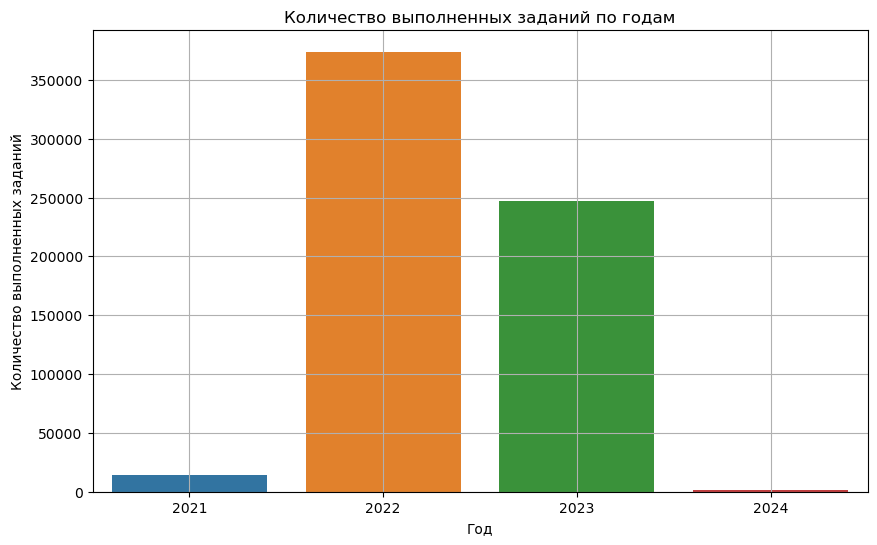

In [42]:
plt.figure(figsize=(10, 6))

bar = sns.barplot(data=df_ungroup, x='Year', y='Tasks', estimator=sum, errorbar=None)

bar.set(title='Количество выполненных заданий по годам', xlabel='Год', ylabel='Количество выполненных заданий')
plt.grid(True)
plt.show()

#### График количества регистраций заданий по годам

In [43]:
df_reg = df_result['registration_date'].dt.year.value_counts().reset_index()

In [44]:
df_reg

,registration_date,count
0,2022,30008
1,2023,25934
2,2021,3514


In [45]:
# Процент упадка в количестве регистраций
round(-np.array(df_reg.loc[df_reg['registration_date'] == 2023]['count'])[0] / np.array(df_reg.loc[df_reg['registration_date'] == 2022]['count'])[0] * 100 + 100, 2)

13.58

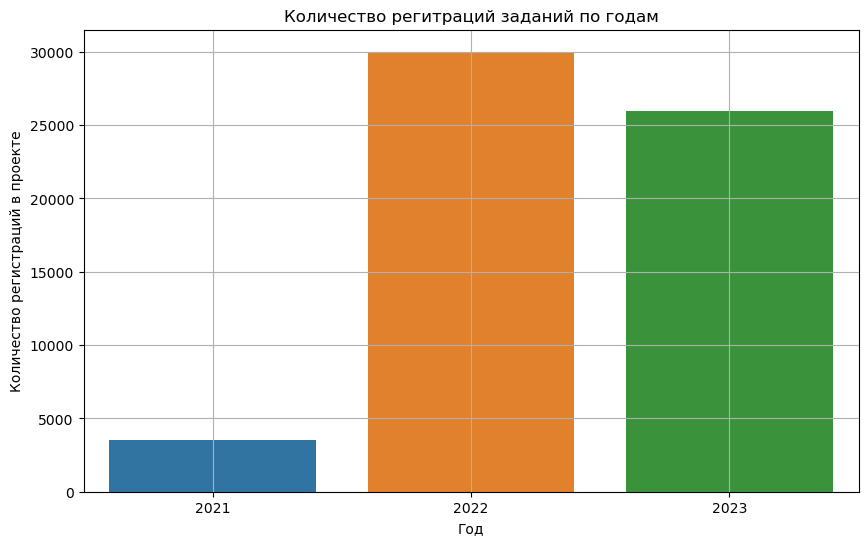

In [47]:
plt.figure(figsize=(10, 6))

bar = sns.barplot(data=df_reg, x='registration_date', y='count', estimator=sum, errorbar=None)

bar.set(title='Количество регитраций заданий по годам', xlabel='Год', ylabel='Количество регистраций в проекте')
plt.grid(True)
plt.show()

В 2022 было сделано на 13.58% меньше регистраций, чем в 2023.
В 2023 регистраций было меньше на 33.81% меньше заданий, чем в 2022 году.

Это может быть связано со многими факторами, например заданий было попросту меньше или люди менее охотно их выполняли и т.д.

In [48]:
df_result

,user_id,role,registration_date,last_active_date,2021,2022,2023,2024
0,79,full,2021-12-30,2023-04-01,1,2,1,0
1,80,full,2021-11-22,2023-01-30,2,1,1,0
2,82,full,2021-11-22,2021-12-09,1,0,0,0
3,83,full,2021-11-26,2023-04-01,2,3,1,0
4,84,full,2021-11-25,2023-05-22,2,5,1,0
...,...,...,...,...,...,...,...,...
59451,231193,full,2023-12-31,2023-12-31,0,0,1,0
59452,231195,full,2023-12-31,2023-12-31,0,0,1,0
59453,231197,full,2023-12-31,2024-07-08,0,0,0,1
59454,231201,full,2023-12-31,2023-12-31,0,0,0,0


#### Посчитаю метрику MAU из начального датафрейма

In [49]:
sessions_closed= pd.read_csv('sessions_closed.csv')

In [50]:
df = sessions_closed.copy()

In [51]:
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed').dt.date
df['updated_at'] = pd.to_datetime(df['updated_at'], format='mixed').dt.date

In [52]:
df_1 = df[['user_id', 'created_at']].rename(columns={'created_at':'active_date'})

Если статус updated_at > created_at и статусы
- 103 - дата последней активности.
- 101 - дата последней активности.

In [53]:
df_2 = df[(df['updated_at'] > df['created_at']) & ((df['status'] == 101)  | (df['status'] == 103))]

In [54]:
df_2 = df_2[['user_id', 'updated_at']].rename(columns={'updated_at':'active_date'})

In [55]:
df_3 = pd.concat([df_1, df_2])

In [56]:
df_3['active_date'] = pd.to_datetime(df_3['active_date'])

In [57]:
# Извлечение года и месяца из active_date
df_3['year'] = df_3['active_date'].dt.year
df_3['month'] = df_3['active_date'].dt.month

In [58]:
# поссчитаю mau
mau = df_3.groupby(['year', 'month'], as_index=False)['user_id'].nunique()

In [59]:
mau['date'] = pd.to_datetime(mau[['year', 'month']].assign(day=1)) + pd.offsets.MonthEnd(0)

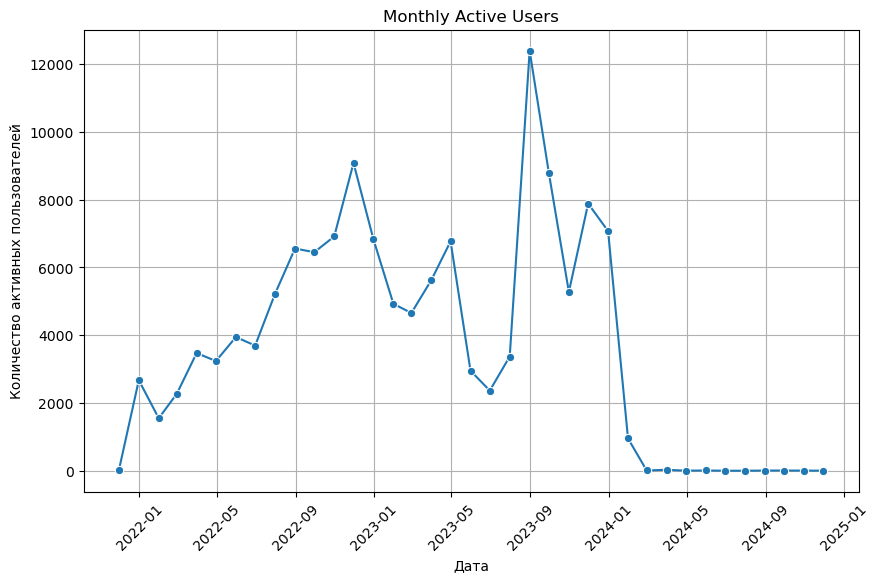

In [60]:
# Построение графика
plt.figure(figsize=(10, 6))
sns.lineplot(data=mau, x='date', y='user_id', marker='o')

# Настройки графика
plt.title("Monthly Active Users")
plt.xlabel("Дата")
plt.ylabel("Количество активных пользователей")
plt.xticks(rotation=45)  # Поворот меток на оси X для удобства чтения
plt.grid(True)  # Включить сетку

plt.show()

Всё, я устал :)

- По графику видно значительную просадку летом 2023 года. Возможно люди разъехали по дачам и отпускам и им было не до заданий
- С другой стороны летом 2022 года показатели летом были возрастающими и люди пользовались платформой
- Про 2024 год без комментариев. Думаю нужно обновить данные за 2024 год